# CO$_2$ Concentration Forecasting with **_Gaussian Processes_**

In [1]:
import GPy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import explained_variance_score
from time import sleep

In [4]:
co2_data_file = 'co2_mm_mlo.csv'

co2_data = pd.read_csv(co2_data_file, sep=r'\s+')

In [5]:
# leave only data 1975 - 2020
co2_data_train = co2_data[co2_data.year < 2015].copy()
co2_data_test = co2_data[co2_data.year >= 2015].copy()

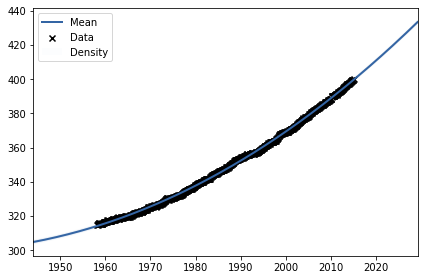

In [6]:
x_year = co2_data_train.decimal_date.values.reshape(-1, 1)
y_year = co2_data_train.deseasonalized.values.reshape(-1, 1)

model_year = GPy.models.GPRegression(x_year, y_year, GPy.kern.PolynomialBasisFuncKernel(input_dim=1, degree=3))
model_year.optimize()

model_year.plot(plot_density=True)
plt.show()

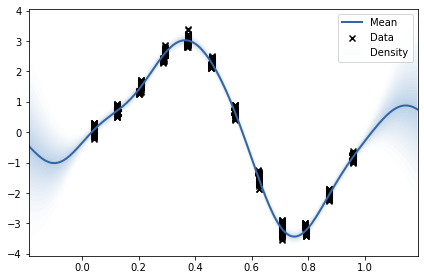

In [7]:
x_month = co2_data_train.decimal_date.values.reshape(-1, 1) % 1
y_month = (co2_data_train.monthly_average - co2_data_train.deseasonalized).values.reshape(-1, 1)

model_month = GPy.models.GPRegression(x_month, y_month, GPy.kern.PeriodicExponential(input_dim=1))
model_month.optimize()

model_month.plot(plot_density=True)
plt.show()


In [8]:
def predict(decimal_date):
    y_year_pred, y_year_pred_var = model_year.predict(decimal_date.values.reshape(-1, 1))
    y_month_pred, y_month_pred_var = model_month.predict((decimal_date % 1).values.reshape(-1, 1))

    y_pred = (y_year_pred + y_month_pred)[:, 0]
    y_pred_var = (y_year_pred_var + y_month_pred_var)[:, 0]
    y_pred_std = np.sqrt(y_pred_var)

    return y_pred, y_pred_std


def plot_prediction(co2_data):
    y_pred, y_pred_std = predict(co2_data.decimal_date)

    plt.plot(co2_data.decimal_date, y_pred, color='magenta', label='Predicted')
    plt.fill_between(co2_data.decimal_date, y_pred - y_pred_std * 1.96, y_pred + y_pred_std * 1.96,
                     color='pink', alpha=0.5, label='95% Confidence Interval')
    plt.plot(co2_data.decimal_date, co2_data.monthly_average, color='darkred', label='Actual Values')

    plt.grid(axis='x')
    plt.legend()
    plt.title('Predicted and actual CO2 concentration\n'
              f'for years {co2_data.year.min()}-{co2_data.year.max()}')
    plt.ylabel('Monthly average CO2 concentration (ppm)')
    plt.xlabel('Date')
    plt.show()


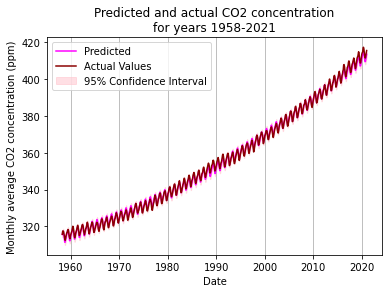

In [9]:
plot_prediction(co2_data)

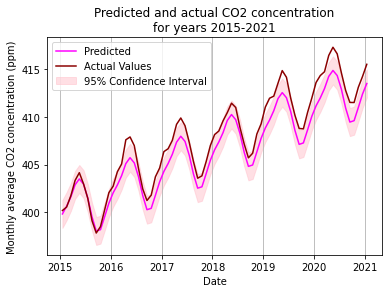

In [10]:
plot_prediction(co2_data_test)

In [11]:
print('Test Data R² =', explained_variance_score(co2_data_test.monthly_average, predict(co2_data_test.decimal_date)[0]))

Test Data R² = 0.9795020772346872
